<a href="https://colab.research.google.com/github/iemio/torch/blob/main/notebook_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.5.1+cu121'

In [11]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
zip_file_path = data_path / "pizza_steak_sushi.zip"
download_url = "https://github.com/iemio/torch/raw/refs/heads/main/pizza_steak_sushi.zip"


# If the image folder doesn't exist, download and prepare it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    try:
        # Download pizza, steak, sushi data
        print("Downloading pizza, steak, sushi data...")
        response = requests.get(download_url, stream=True)
        response.raise_for_status()  # Raise an exception for HTTP errors

        with open(zip_file_path, "wb") as f:
            f.write(response.content)

        print("Download completed.")

        # Verify the file size (optional)
        print(f"Downloaded file size: {zip_file_path.stat().st_size} bytes")

        # Unzip the downloaded file
        print("Unzipping pizza, steak, sushi data...")
        with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
            zip_ref.extractall(image_path)

        print("Data successfully extracted.")
    except requests.exceptions.RequestException as e:
        print(f"Download failed: {e}")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        # Clean up partial files if extraction fails
        if zip_file_path.exists() and not image_path.is_dir():
            zip_file_path.unlink(missing_ok=True)
            print("Cleaned up partial ZIP file.")


Did not find data/pizza_steak_sushi directory, creating one...
Download completed.
Downloaded file size: 15737296 bytes
Unzipping pizza, steak, sushi data...
Data successfully extracted.


In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#Visualize an image

### Using PIL(Pillow) library

Random image path: data/pizza_steak_sushi/train/pizza/12301.jpg
Image class: pizza
Image height: 512
Image width: 384


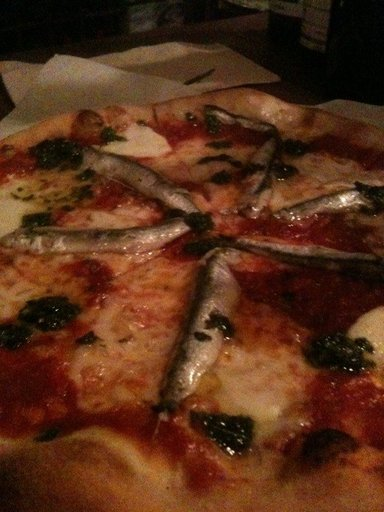

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

###Using Matplotlib library

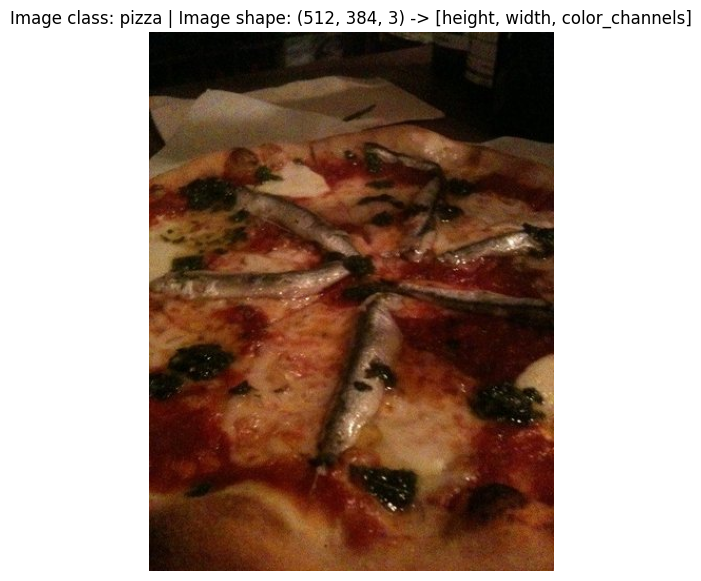

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array as matplotlib works with numpy array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

##Transforming data

**torchvision.transforms** contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

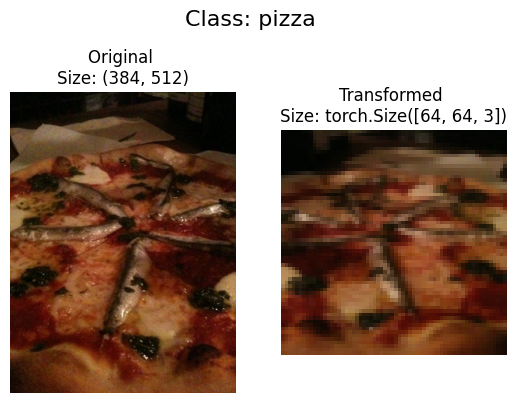

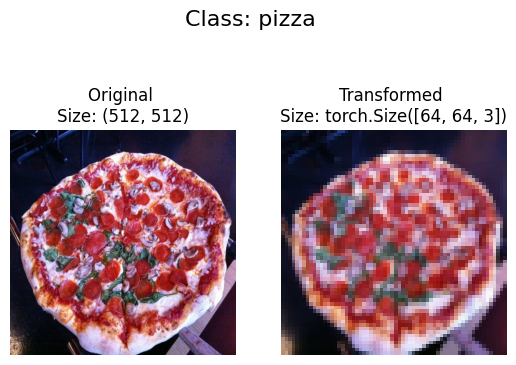

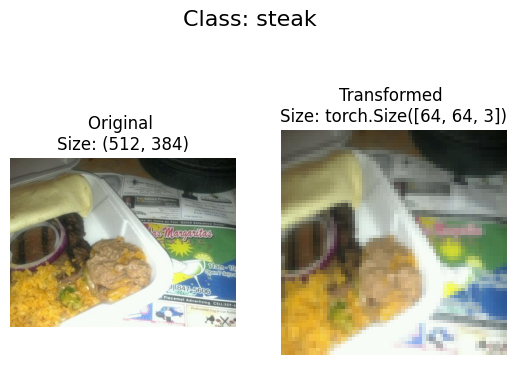

In [14]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

#Making dataset out of data

##1. Loading Image Data Using ImageFolder class in PyTorch's torchvision library

In [16]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [17]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [20]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


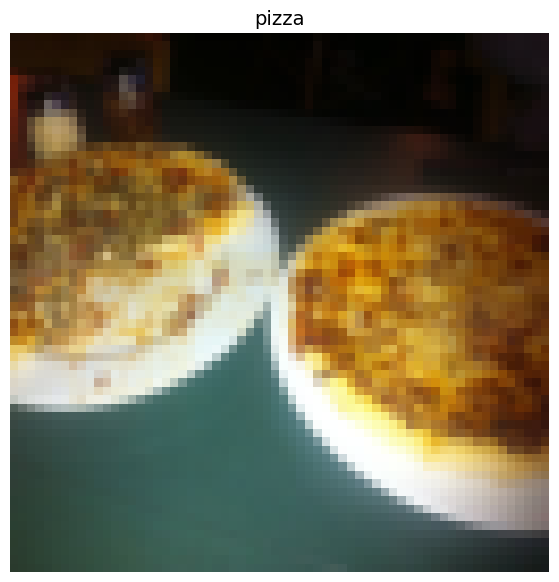

In [21]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

###Turn loaded images into DataLoader's

Turning our Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a batch_size=1 and num_workers=1.

What's num_workers?

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value num_workers is set to, the more compute power PyTorch will use to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's os.cpu_count().

This ensures the DataLoader recruits as many cores as possible to load data

In [22]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a63b634bdd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a63b6348a90>)

In [23]:
import os
os.cpu_count()

2

## 2. Loading Image Data with a Custom Dataset

- Python's os for dealing with directories (our data is stored in directories).
- Python's pathlib for dealing with filepaths (each of our images has a unique filepath).
- torch for all things PyTorch.
- PIL's Image class for loading images.
- torch.utils.data.Dataset to subclass and create our own custom Dataset.
- torchvision.transforms to turn our images into tensors.
- Various types from Python's typing module to add type hints to our code.

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names

- Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
- Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
- Turn the class names into a dictionary of numerical labels, one for each class.

In [26]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [27]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [28]:

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom Dataset to replicate ImageFolder

- Subclass torch.utils.data.Dataset.
- Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).
- Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).
- Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).
- Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).
- Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.

In [29]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [30]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [31]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a63b56ebd90>,
 <__main__.ImageFolderCustom at 0x7a63b56ebed0>)

In [32]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [33]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [34]:

train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### Create a function to display random images

In [36]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

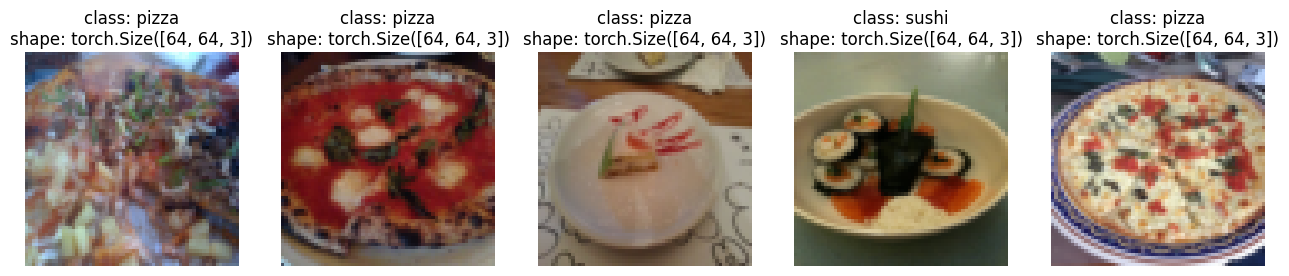

In [37]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


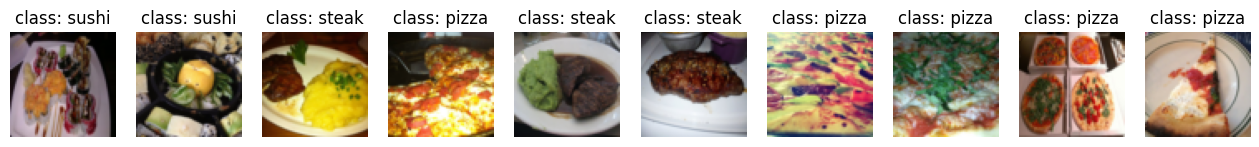

In [38]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

###Turn custom loaded images into DataLoader's